In [27]:
# import functions:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import statistics
import scipy

### STEP 1:

Transform the output data format into a `networkx` object first.

In [29]:
def read_nefi_graph(tracing_file_name):
    '''
    Parameter:  
    ----------
    tracing_file_name: string, path to vein txt file, graph extracted from nefi
    
    Returns:
    ----------
    G_trace: nx graph, with graph attribute for dimensions (xmin, xmax, y_min, y_max, xy ratio)
    
    '''
    
    # read in output from nefi:
    G_trace = nx.read_multiline_adjlist(tracing_file_name, delimiter='|')
    
    # remove unwanted attr:
    for e in G_trace.edges:
        del G_trace.edges[e]['pixels']
        del G_trace.edges[e]['width']
        del G_trace.edges[e]['width_var']
        
    # add node node attr:
    name_map = {}
    for n in G_trace:
        name_map[n] = tuple(map(int, n[1:-1].split(', ')))
    
    # rename the node to coordinate tuples to replace the strings:
    G_trace = nx.relabel_nodes(G_trace, name_map)
    
    # add graph feature to help recovering the dimention ratio in plotting
    mins = np.min(np.array(list(G_trace.nodes())), 0)
    maxes = np.max(np.array(list(G_trace.nodes())), 0)
    
    G_trace.graph['x_min'] = mins[0]
    G_trace.graph['y_min'] = mins[1]
    
    G_trace.graph['x_max'] = maxes[0]
    G_trace.graph['y_max'] = maxes[1]
    
    G_trace.graph['ratio'] = (maxes[0] - mins[0]) / (maxes[1] - mins[1])
    
    return G_trace

### STEP 2:

Input your data



In [37]:
# file path and name:
tracing_file_name = 'your_path/your_nefi_output.txt'

In [39]:
# read in the graph:
G_trace = read_nefi_graph(tracing_file_name)

##Find the number of nodes and edges,
#edges are the links (lines)
#Nodes are the points (ends)
N, K = G_trace.order(), G_trace.size()

print('The number of nodes is', N)
print('The number of edges is', K)
terminal_nodes = [x for x in G_trace.nodes() if G_trace.degree(x)==1]
len(terminal_nodes)
print('The number of terminal nodes is', len(terminal_nodes))



The number of nodes is 26
The number of edges is 26
The number of terminal nodes is 13


### STEP 3:

Graph visualization

In [8]:
def quick_plot(G):
    '''
    quick plotting for spatial graphs;
    since each node's named after it's coordinate, we can just use that to plot it's spatial position.
    '''
    node_positions = {}
    
    for node in G.nodes:
        node_positions[node] = node
    
    # plotting with figure dimentions matching the graph's dimension:
    fig, ax = plt.subplots(figsize=(8, 8/G.graph['ratio']))
    
    nx.draw(G, pos=node_positions, node_size= 20,  ax = ax) 
    
    plt.tight_layout()
    plt.show()   
        
    return

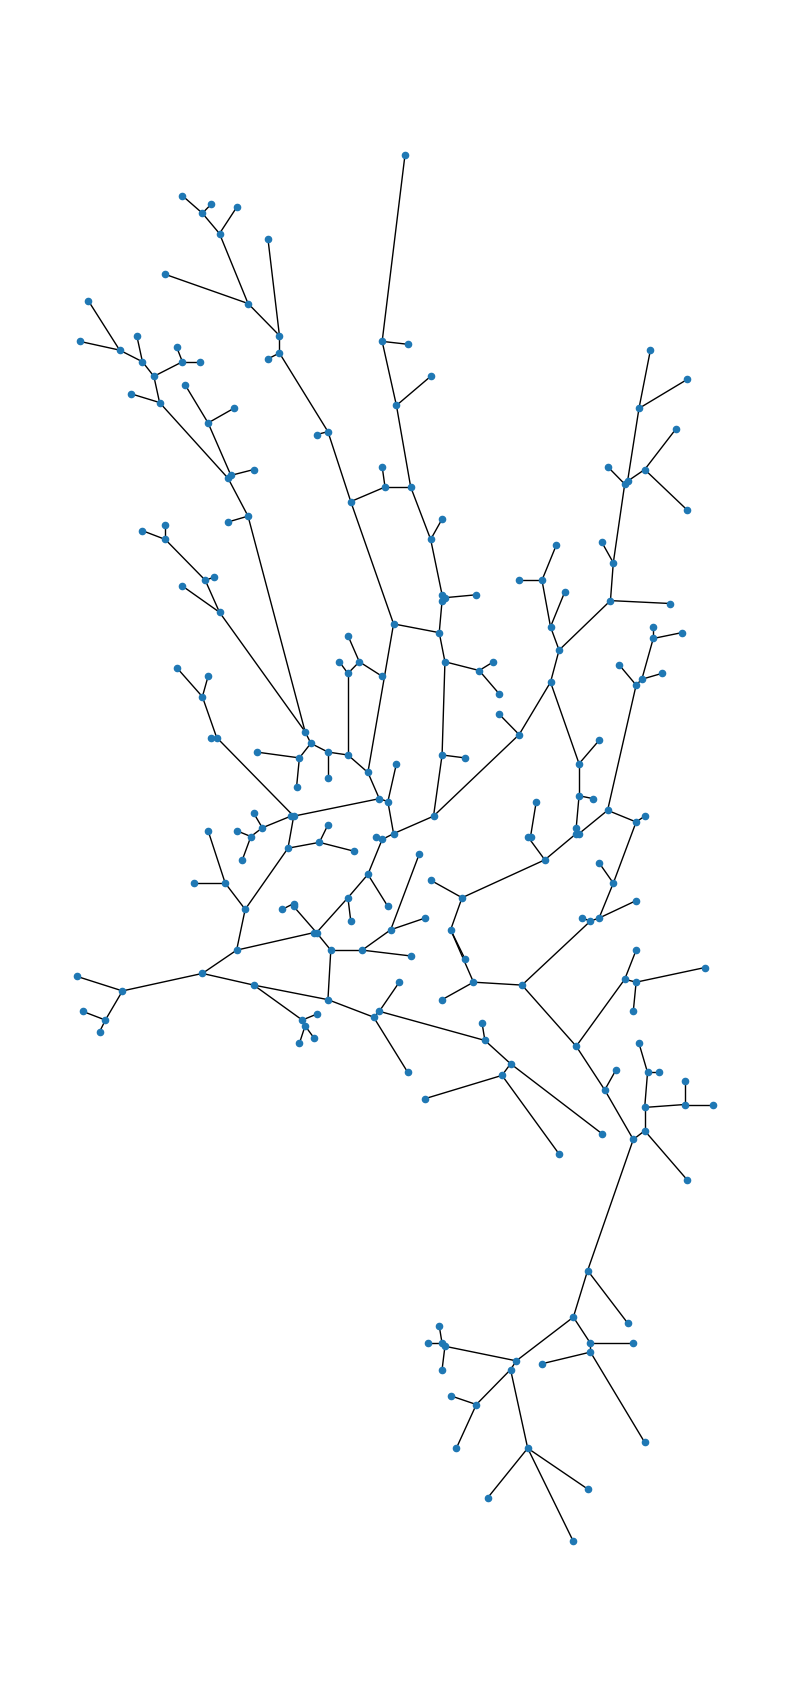

In [9]:
quick_plot(G_trace)

Make graph with external boundaries around it

In [10]:
node_list = list(G_trace.nodes)
convex_hull = scipy.spatial.ConvexHull(node_list)
boundary = np.array(node_list)[idxes]
boundary = boundary.tolist()
boundary.append(boundary[0])
boundary = np.array(boundary)

node_positions = {}

for node in G_trace.nodes:
    node_positions[node] = node

# plotting with figure dimentions matching the graph's dimension:
fig, ax = plt.subplots(figsize=(8, 8/G_trace.graph['ratio']))

nx.draw(G_trace, pos=node_positions, node_size= 20,  ax = ax) 

plt.plot(boundary[:,0], boundary[:,1], c = 'C1')

plt.tight_layout()
plt.show() 

## STEP 4: Calculation of properties


### Analysis of branching degree

In [19]:
#Number of connected components, if >1 then there are smaller networks not connected.
#There should only be one connected component, as the ductal tree is one network
nx.number_connected_components(G_trace)

1

In [20]:
# number of cycles, which is something that you might want to remove bc you know
# that the tree network should not have cycles! 
# but that also depend on how sensetive the properties that you care depend on 
# whether there are cycles.

cycles = list(nx.cycle_basis(G_trace))

In [21]:
len(cycles)

7

In [22]:
# plot the degree distribution:
degree_sequence = sorted((d for n, d in G_trace.degree()), reverse=True)

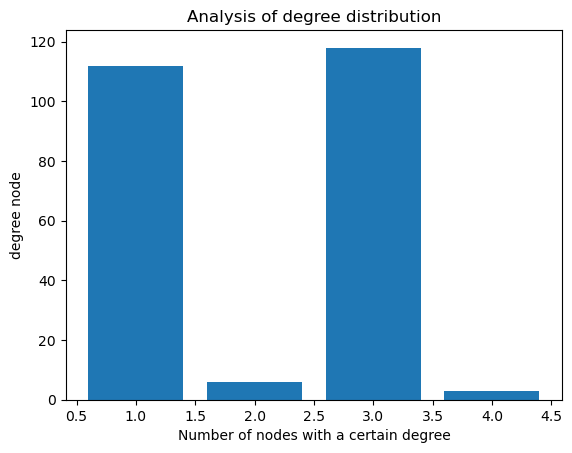

In [23]:
plt.bar(*np.unique(degree_sequence, return_counts=True), label = 'Degree distribution')
plt.title('Analysis of degree distribution')
plt.xlabel('Number of nodes with a certain degree')
plt.ylabel('degree node')
plt.show()

### Analysis of number of edges and ducts

In [24]:
##Find the number of nodes and edges,

#edges are the links (lines)
#Nodes are the points (ends)
N, K = G_trace.order(), G_trace.size()

print('The number of nodes is', N)
print('The number of edges is', K)

The number of nodes is 239
The number of edges is 245


In [25]:
##Find terminal nodes, which are the actual alveoli

terminal_nodes = [x for x in G_trace.nodes() if G_trace.degree(x)==1]
len(terminal_nodes)

112

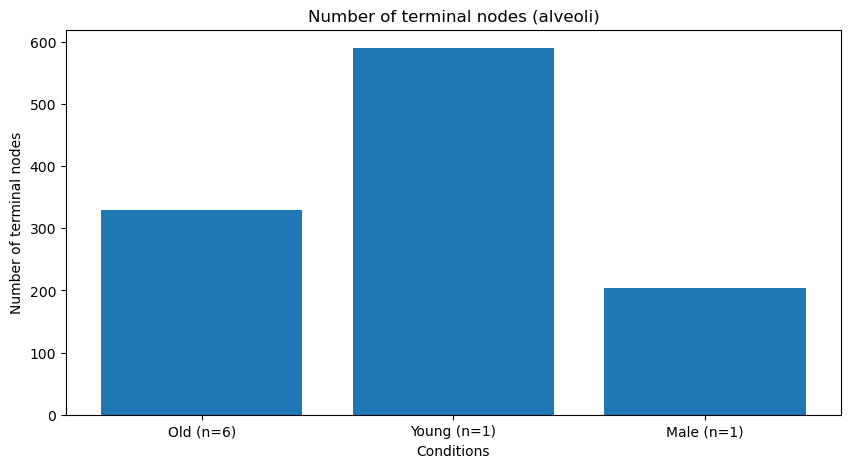

In [53]:
##For plotting of alveoli, include your information about your experiment in here:

alveoli_condition1 = []
alveoli_condition2 = []

data = {'Condition 1 (n=x)':statistics.mean(alveoli_condition1), 'Condition 2 (n=x)':statistics.mean(alveoli_condition2)}

courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values)
plt.title('Number of terminal nodes (alveoli)')
plt.xlabel('Conditions')
plt.ylabel('Number of terminal nodes')
plt.show()

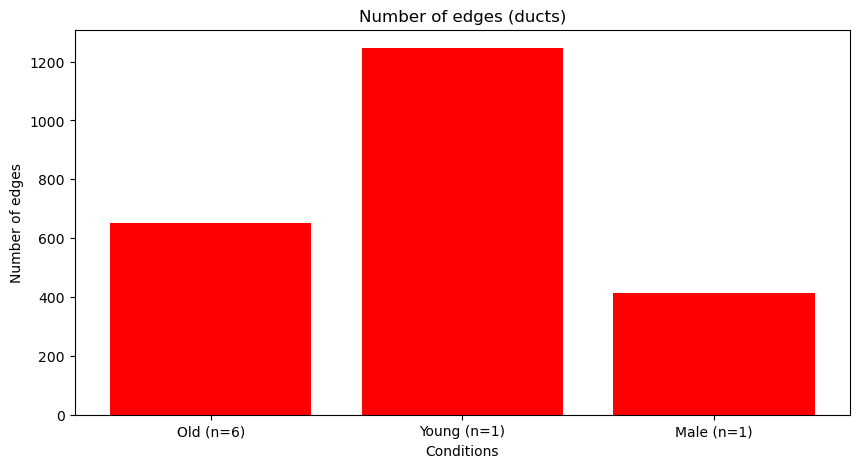

In [54]:
##For plotting of ducts, include your information about your experiment in here:

ducts_condition1 = []
ducts_condition2 = []

data = {'Condition 1 (n=x)':statistics.mean(ducts_condition1), 'Condition 2 (n=x)':statistics.mean(ducts_condition2)}

courses = list(data.keys())
values = list(data.values())
fig = plt.figure(figsize = (10, 5))
plt.bar(courses, values)
plt.title('Number of ducts')
plt.xlabel('Conditions')
plt.ylabel('Number of ducts')
plt.show()